By [Kevin Michalewicz](https://kevinmichalewicz.com) on April 2023

This notebook details how to pre-process antibody structures to obtain aligned normal mode correlation maps. After that, training and evaluation using the ANTIPASTI model is explained.

In [1]:
# General imports
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import math
import optuna

from matplotlib.colors import CenteredNorm
from sklearn.model_selection import KFold

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief
from torch.nn import MSELoss
from torchmetrics import PearsonCorrCoef

# ANTIPASTI
from antipasti.model.model import ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.explaining_utils import plot_map_with_regions
from antipasti.utils.torch_utils import create_test_set, save_checkpoint, training_routine

# Pre-processing

In [2]:
modes = 'all' # Number of normal modes to consider. Relevant if renew_maps is True
renew_maps = True # True to compute again all the normal mode correlation maps
renew_residues = True # True to retrieve again all the chain lengths 
dccm_map_path = 'dccm_maps_full_ags_all/' # NM correlation maps or contact maps are saved here
ag_agnostic = False # If True, only the antibody is considered
contact_maps = False # True to compute contact maps and False to compute NM correlation maps
cmaps_thr = 8.0 # If contact_maps is True, then this is the thresholding parameter, otherwise irrelevant

pathological = ['5omm', '5i5k', '1uwx', '1mj7', '1qfw', '1qyg', '4ffz', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t', '3fku', '1oau', '1oay']
scfv = ['4gqp', '3etb', '3gkz', '3uze', '3uzq', '3gm0', '4f9l', '6ejg', '6ejm', '1h8s', '5dfw', '6cbp', '4f9p', '5kov', '1dzb', '5j74', '5aaw', '3uzv', '5aam', '3ux9', '5a2j', '5a2k', '5a2i', '3fku', '5yy4', '3uyp', '5jyl', '1y0l', '1p4b', '3kdm', '4lar', '4ffy', '2ybr', '1mfa', '5xj3', '5xj4', '4kv5', '5vyf'] 
pathological += scfv

preprocessed_data = Preprocessing(dccm_map_path=dccm_map_path, modes=modes, pathological=pathological, renew_maps=renew_maps, renew_residues=renew_residues, ag_agnostic=ag_agnostic, cmaps=contact_maps, cmaps_thr=cmaps_thr)

Map 1 out of 634 processed.
Map 26 out of 634 processed.
Map 51 out of 634 processed.
Map 76 out of 634 processed.
Map 101 out of 634 processed.
Map 126 out of 634 processed.
Map 151 out of 634 processed.
Map 176 out of 634 processed.
Map 201 out of 634 processed.
Map 226 out of 634 processed.
Map 251 out of 634 processed.
Map 276 out of 634 processed.
Map 301 out of 634 processed.
Map 326 out of 634 processed.
Map 351 out of 634 processed.
Map 376 out of 634 processed.
Map 401 out of 634 processed.
Map 426 out of 634 processed.
Map 451 out of 634 processed.
Map 476 out of 634 processed.
Map 501 out of 634 processed.
Map 526 out of 634 processed.
Map 551 out of 634 processed.
Map 576 out of 634 processed.
Map 601 out of 634 processed.
Map 626 out of 634 processed.


In [3]:
preprocessed_data.train_x.shape

(634, 288, 288)

Let's plot some histograms to see the distributions of the chain lengths and the binding affinities.

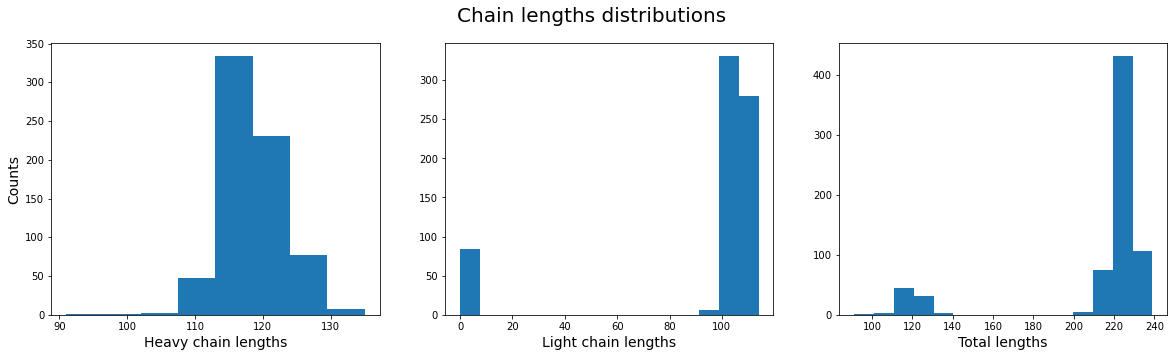

In [4]:
title_size = 20
font_size = 14

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Chain lengths distributions', size=title_size)
ax1.hist(preprocessed_data.heavy, 8)
ax2.hist(preprocessed_data.light, 15)
ax3.hist([sum(x) for x in zip(preprocessed_data.heavy, preprocessed_data.light)], 15)

# Changing plotting settings
ax1.set_ylabel('Counts', size=font_size)
ax1.set_xlabel('Heavy chain lengths', size=font_size)
ax2.set_xlabel('Light chain lengths', size=font_size)
ax3.set_xlabel('Total lengths', size=font_size)

plt.show()

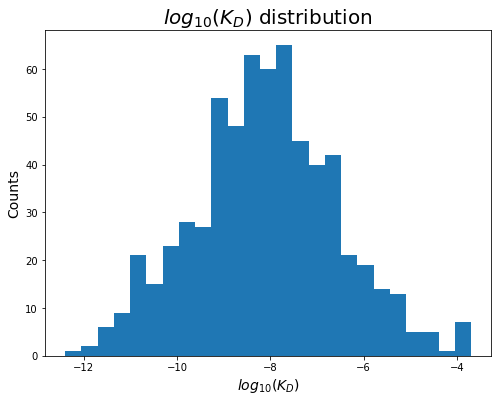

In [5]:
fig = plt.figure(figsize=(8, 6))
plt.title('$log_{10}(K_D)$ distribution', size=title_size)
plt.hist(preprocessed_data.train_y, 25)
plt.xlabel('$log_{10}(K_D)$', size=font_size)
plt.ylabel('Counts', size=font_size)
plt.show()

A sample normal mode correlation map before and after adding the blank pixels.

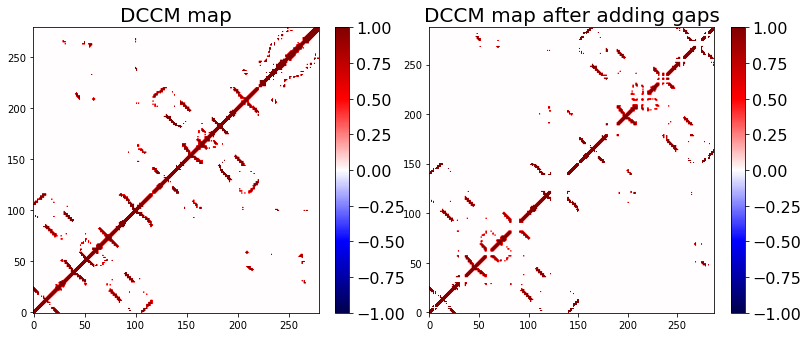

In [6]:
input_shape = preprocessed_data.train_x.shape[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.25))
im1 = ax1.imshow(preprocessed_data.raw_imgs[304], origin='lower', cmap='seismic', norm=CenteredNorm())
im2 = ax2.imshow(preprocessed_data.train_x[304].reshape(input_shape, input_shape), origin='lower', cmap='seismic', norm=CenteredNorm())

ax1.set_title('DCCM map', size=title_size)
ax2.set_title('DCCM map after adding gaps', size=title_size)

cb1 = plt.colorbar(im1, ax=ax1, fraction=0.045)
cb2 = plt.colorbar(im2, ax=ax2, fraction=0.045)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)
cb1.ax.tick_params(labelsize=16) 
cb2.ax.tick_params(labelsize=16) 

plt.show()

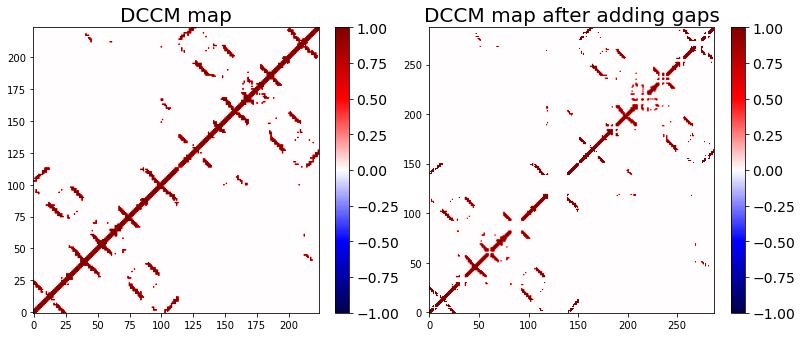

In [7]:

input_shape = preprocessed_data.train_x.shape[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.25))
im1 = ax1.imshow(preprocessed_data.raw_imgs[22], origin='lower', cmap='seismic', norm=CenteredNorm())
im2 = ax2.imshow(preprocessed_data.train_x[22].reshape(input_shape, input_shape), origin='lower', cmap='seismic', norm=CenteredNorm())

ax1.set_title('DCCM map', size=title_size)
ax2.set_title('DCCM map after adding gaps', size=title_size)

cb1 = plt.colorbar(im1, ax=ax1, fraction=0.045)
cb2 = plt.colorbar(im2, ax=ax2, fraction=0.045)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)
cb1.ax.tick_params(labelsize=14) 
cb2.ax.tick_params(labelsize=14) 

plt.show()

In [8]:
# The test set is generated
train_x, test_x, train_y, test_y, idx_tr, idx_te = create_test_set(preprocessed_data.train_x, preprocessed_data.train_y, test_size=0.032, random_state=398)

In [9]:
[preprocessed_data.labels[i] for i in idx_te]

['1flr',
 '4ps4',
 '3ubx',
 '2r1y',
 '5o2u',
 '6msy',
 '5myx',
 '6bkc',
 '2jix',
 '5kn5',
 '4x7d',
 '2yk1',
 '5hvf',
 '3fn0',
 '3ma9',
 '1ct8',
 '5cjq',
 '5otj',
 '2h9g',
 '3ghe',
 '1yei']

In [37]:
# Hyperparameters
n_filters = 4
filter_size = 4
pooling_size = 2
learning_rate = 0.00027253018778843 * 0.4 * 2


# Defining the model, optimiser and loss function
model = ANTIPASTI(n_filters=n_filters, filter_size=filter_size, pooling_size=pooling_size, input_shape=input_shape, l1_lambda=0.002, mode='linear')
criterion = MSELoss() 
optimiser = AdaBelief(model.parameters(), lr=learning_rate, weight_decay=False, eps=1e-8, print_change_log=False) 
print(model)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
ANTIPASTI(
  (fc1): Linear(in_features=82944, out_features=1, bias=False)
)


In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [39]:
count_parameters(model.fc1)

82944

In [40]:
train_losses = []
test_losses = []

In [41]:
model.train()
n_max_epochs = 23 * 3
max_corr = 0.4
batch_size = 32

train_loss, test_loss, inter_filter, y_test, output_test = training_routine(model, criterion, optimiser, train_x, test_x, train_y, test_y, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size)

# Saving the losses
train_losses.extend(train_loss)
test_losses.extend(test_loss)

tensor(0.2883, grad_fn=<MulBackward0>)
tensor(0.2964, grad_fn=<MulBackward0>)
tensor(0.3045, grad_fn=<MulBackward0>)
tensor(0.3069, grad_fn=<MulBackward0>)
tensor(0.3061, grad_fn=<MulBackward0>)
tensor(0.3036, grad_fn=<MulBackward0>)
tensor(0.3030, grad_fn=<MulBackward0>)
tensor(0.3024, grad_fn=<MulBackward0>)
tensor(0.3016, grad_fn=<MulBackward0>)
tensor(0.3007, grad_fn=<MulBackward0>)
tensor(0.2997, grad_fn=<MulBackward0>)
tensor(0.2986, grad_fn=<MulBackward0>)
tensor(0.2974, grad_fn=<MulBackward0>)
tensor(0.2962, grad_fn=<MulBackward0>)
tensor(0.2948, grad_fn=<MulBackward0>)
tensor(0.2934, grad_fn=<MulBackward0>)
tensor(0.2919, grad_fn=<MulBackward0>)
tensor(0.2904, grad_fn=<MulBackward0>)
tensor(0.2887, grad_fn=<MulBackward0>)
tensor(0.2870, grad_fn=<MulBackward0>)
tensor([[-10.9909]])
tensor([[-9.3010]])
------------------------
tensor([[-11.0472]])
tensor([[-11.2441]])
------------------------
tensor([[-11.1560]])
tensor([[-7.5986]])
------------------------
tensor([[-11.2896]])


tensor(0.1155, grad_fn=<MulBackward0>)
tensor(0.1133, grad_fn=<MulBackward0>)
tensor(0.1110, grad_fn=<MulBackward0>)
tensor(0.1088, grad_fn=<MulBackward0>)
tensor(0.1065, grad_fn=<MulBackward0>)
tensor(0.1043, grad_fn=<MulBackward0>)
tensor(0.1022, grad_fn=<MulBackward0>)
tensor(0.1000, grad_fn=<MulBackward0>)
tensor(0.0979, grad_fn=<MulBackward0>)
tensor(0.0958, grad_fn=<MulBackward0>)
tensor(0.0937, grad_fn=<MulBackward0>)
tensor([[-8.0988]])
tensor([[-9.3010]])
------------------------
tensor([[-8.2007]])
tensor([[-11.2441]])
------------------------
tensor([[-8.2676]])
tensor([[-7.5986]])
------------------------
tensor([[-8.2392]])
tensor([[-4.5086]])
------------------------
tensor([[-5.1921]])
tensor([[-9.1612]])
------------------------
tensor([[-8.3059]])
tensor([[-7.]])
------------------------
tensor([[-8.2151]])
tensor([[-8.1643]])
------------------------
tensor([[-8.0584]])
tensor([[-9.0969]])
------------------------
tensor([[-8.1728]])
tensor([[-7.5229]])
--------------

tensor(0.0364, grad_fn=<MulBackward0>)
tensor(0.0364, grad_fn=<MulBackward0>)
tensor(0.0365, grad_fn=<MulBackward0>)
tensor(0.0365, grad_fn=<MulBackward0>)
tensor(0.0366, grad_fn=<MulBackward0>)
tensor(0.0366, grad_fn=<MulBackward0>)
tensor(0.0366, grad_fn=<MulBackward0>)
tensor([[-7.9635]])
tensor([[-9.3010]])
------------------------
tensor([[-8.2145]])
tensor([[-11.2441]])
------------------------
tensor([[-8.2710]])
tensor([[-7.5986]])
------------------------
tensor([[-8.0088]])
tensor([[-4.5086]])
------------------------
tensor([[-5.9807]])
tensor([[-9.1612]])
------------------------
tensor([[-8.2909]])
tensor([[-7.]])
------------------------
tensor([[-8.1200]])
tensor([[-8.1643]])
------------------------
tensor([[-8.1047]])
tensor([[-9.0969]])
------------------------
tensor([[-8.1612]])
tensor([[-7.5229]])
------------------------
tensor([[-8.1741]])
tensor([[-9.9914]])
------------------------
tensor([[-5.1148]])
tensor([[-8.4559]])
------------------------
tensor([[-7.913

tensor(0.0402, grad_fn=<MulBackward0>)
tensor(0.0403, grad_fn=<MulBackward0>)
tensor(0.0404, grad_fn=<MulBackward0>)
tensor(0.0405, grad_fn=<MulBackward0>)
tensor(0.0406, grad_fn=<MulBackward0>)
tensor(0.0407, grad_fn=<MulBackward0>)
tensor(0.0407, grad_fn=<MulBackward0>)
tensor(0.0408, grad_fn=<MulBackward0>)
tensor(0.0409, grad_fn=<MulBackward0>)
tensor(0.0410, grad_fn=<MulBackward0>)
tensor(0.0410, grad_fn=<MulBackward0>)
tensor(0.0411, grad_fn=<MulBackward0>)
tensor(0.0412, grad_fn=<MulBackward0>)
tensor(0.0412, grad_fn=<MulBackward0>)
tensor(0.0413, grad_fn=<MulBackward0>)
tensor(0.0413, grad_fn=<MulBackward0>)
tensor(0.0414, grad_fn=<MulBackward0>)
tensor(0.0415, grad_fn=<MulBackward0>)
tensor([[-7.9104]])
tensor([[-9.3010]])
------------------------
tensor([[-8.3280]])
tensor([[-11.2441]])
------------------------
tensor([[-8.3790]])
tensor([[-7.5986]])
------------------------
tensor([[-7.8196]])
tensor([[-4.5086]])
------------------------
tensor([[-6.7607]])
tensor([[-9.1612]

tensor(0.0464, grad_fn=<MulBackward0>)
tensor(0.0464, grad_fn=<MulBackward0>)
tensor(0.0465, grad_fn=<MulBackward0>)
tensor(0.0465, grad_fn=<MulBackward0>)
tensor(0.0466, grad_fn=<MulBackward0>)
tensor(0.0467, grad_fn=<MulBackward0>)
tensor(0.0467, grad_fn=<MulBackward0>)
tensor(0.0468, grad_fn=<MulBackward0>)
tensor(0.0468, grad_fn=<MulBackward0>)
tensor(0.0469, grad_fn=<MulBackward0>)
tensor(0.0469, grad_fn=<MulBackward0>)
tensor([[-7.6937]])
tensor([[-9.3010]])
------------------------
tensor([[-8.2560]])
tensor([[-11.2441]])
------------------------
tensor([[-8.3205]])
tensor([[-7.5986]])
------------------------
tensor([[-7.4531]])
tensor([[-4.5086]])
------------------------
tensor([[-7.2364]])
tensor([[-9.1612]])
------------------------
tensor([[-8.0970]])
tensor([[-7.]])
------------------------
tensor([[-8.0452]])
tensor([[-8.1643]])
------------------------
tensor([[-8.0256]])
tensor([[-9.0969]])
------------------------
tensor([[-8.1972]])
tensor([[-7.5229]])
--------------

tensor([[-7.4559]])
------------------------
Epoch :  20 	 train loss:  2.278400489595547 train MSE:  tensor(2.2255, grad_fn=<AddBackward0>) test MSE:  3.2161544208592248
Corr: 0.07495513133904257
tensor(0.0512, grad_fn=<MulBackward0>)
tensor(0.0513, grad_fn=<MulBackward0>)
tensor(0.0514, grad_fn=<MulBackward0>)
tensor(0.0514, grad_fn=<MulBackward0>)
tensor(0.0515, grad_fn=<MulBackward0>)
tensor(0.0516, grad_fn=<MulBackward0>)
tensor(0.0517, grad_fn=<MulBackward0>)
tensor(0.0518, grad_fn=<MulBackward0>)
tensor(0.0520, grad_fn=<MulBackward0>)
tensor(0.0521, grad_fn=<MulBackward0>)
tensor(0.0522, grad_fn=<MulBackward0>)
tensor(0.0523, grad_fn=<MulBackward0>)
tensor(0.0523, grad_fn=<MulBackward0>)
tensor(0.0524, grad_fn=<MulBackward0>)
tensor(0.0525, grad_fn=<MulBackward0>)
tensor(0.0526, grad_fn=<MulBackward0>)
tensor(0.0527, grad_fn=<MulBackward0>)
tensor(0.0528, grad_fn=<MulBackward0>)
tensor(0.0529, grad_fn=<MulBackward0>)
tensor(0.0530, grad_fn=<MulBackward0>)
tensor([[-7.6134]])
ten

tensor(0.0577, grad_fn=<MulBackward0>)
tensor(0.0578, grad_fn=<MulBackward0>)
tensor(0.0578, grad_fn=<MulBackward0>)
tensor(0.0579, grad_fn=<MulBackward0>)
tensor(0.0579, grad_fn=<MulBackward0>)
tensor(0.0580, grad_fn=<MulBackward0>)
tensor(0.0581, grad_fn=<MulBackward0>)
tensor(0.0581, grad_fn=<MulBackward0>)
tensor(0.0582, grad_fn=<MulBackward0>)
tensor(0.0583, grad_fn=<MulBackward0>)
tensor(0.0584, grad_fn=<MulBackward0>)
tensor(0.0584, grad_fn=<MulBackward0>)
tensor([[-7.4434]])
tensor([[-9.3010]])
------------------------
tensor([[-8.2993]])
tensor([[-11.2441]])
------------------------
tensor([[-8.3995]])
tensor([[-7.5986]])
------------------------
tensor([[-6.8568]])
tensor([[-4.5086]])
------------------------
tensor([[-7.6775]])
tensor([[-9.1612]])
------------------------
tensor([[-7.8053]])
tensor([[-7.]])
------------------------
tensor([[-8.0383]])
tensor([[-8.1643]])
------------------------
tensor([[-7.8638]])
tensor([[-9.0969]])
------------------------
tensor([[-8.325

tensor(0.0639, grad_fn=<MulBackward0>)
tensor(0.0640, grad_fn=<MulBackward0>)
tensor(0.0641, grad_fn=<MulBackward0>)
tensor([[-7.4750]])
tensor([[-9.3010]])
------------------------
tensor([[-8.5055]])
tensor([[-11.2441]])
------------------------
tensor([[-8.6279]])
tensor([[-7.5986]])
------------------------
tensor([[-6.7537]])
tensor([[-4.5086]])
------------------------
tensor([[-7.8199]])
tensor([[-9.1612]])
------------------------
tensor([[-7.8606]])
tensor([[-7.]])
------------------------
tensor([[-8.2292]])
tensor([[-8.1643]])
------------------------
tensor([[-7.9964]])
tensor([[-9.0969]])
------------------------
tensor([[-8.5443]])
tensor([[-7.5229]])
------------------------
tensor([[-8.4383]])
tensor([[-9.9914]])
------------------------
tensor([[-6.7196]])
tensor([[-8.4559]])
------------------------
tensor([[-7.6758]])
tensor([[-8.1308]])
------------------------
tensor([[-7.9784]])
tensor([[-10.5229]])
------------------------
tensor([[-7.9407]])
tensor([[-4.3979]])


tensor(0.0687, grad_fn=<MulBackward0>)
tensor(0.0688, grad_fn=<MulBackward0>)
tensor(0.0689, grad_fn=<MulBackward0>)
tensor(0.0689, grad_fn=<MulBackward0>)
tensor(0.0690, grad_fn=<MulBackward0>)
tensor(0.0690, grad_fn=<MulBackward0>)
tensor(0.0691, grad_fn=<MulBackward0>)
tensor(0.0692, grad_fn=<MulBackward0>)
tensor(0.0692, grad_fn=<MulBackward0>)
tensor(0.0693, grad_fn=<MulBackward0>)
tensor(0.0694, grad_fn=<MulBackward0>)
tensor(0.0694, grad_fn=<MulBackward0>)
tensor(0.0695, grad_fn=<MulBackward0>)
tensor([[-7.2895]])
tensor([[-9.3010]])
------------------------
tensor([[-8.4654]])
tensor([[-11.2441]])
------------------------
tensor([[-8.5976]])
tensor([[-7.5986]])
------------------------
tensor([[-6.4684]])
tensor([[-4.5086]])
------------------------
tensor([[-7.8441]])
tensor([[-9.1612]])
------------------------
tensor([[-7.6442]])
tensor([[-7.]])
------------------------
tensor([[-8.1782]])
tensor([[-8.1643]])
------------------------
tensor([[-7.8712]])
tensor([[-9.0969]])
-

tensor(0.0747, grad_fn=<MulBackward0>)
tensor(0.0748, grad_fn=<MulBackward0>)
tensor(0.0748, grad_fn=<MulBackward0>)
tensor(0.0749, grad_fn=<MulBackward0>)
tensor(0.0750, grad_fn=<MulBackward0>)
tensor([[-7.0186]])
tensor([[-9.3010]])
------------------------
tensor([[-8.3355]])
tensor([[-11.2441]])
------------------------
tensor([[-8.4818]])
tensor([[-7.5986]])
------------------------
tensor([[-6.1339]])
tensor([[-4.5086]])
------------------------
tensor([[-7.8013]])
tensor([[-9.1612]])
------------------------
tensor([[-7.3434]])
tensor([[-7.]])
------------------------
tensor([[-8.0531]])
tensor([[-8.1643]])
------------------------
tensor([[-7.7254]])
tensor([[-9.0969]])
------------------------
tensor([[-8.3588]])
tensor([[-7.5229]])
------------------------
tensor([[-8.2711]])
tensor([[-9.9914]])
------------------------
tensor([[-6.7294]])
tensor([[-8.4559]])
------------------------
tensor([[-7.3637]])
tensor([[-8.1308]])
------------------------
tensor([[-7.9004]])
tensor([

tensor(0.0800, grad_fn=<MulBackward0>)
tensor(0.0800, grad_fn=<MulBackward0>)
tensor(0.0801, grad_fn=<MulBackward0>)
tensor(0.0801, grad_fn=<MulBackward0>)
tensor(0.0802, grad_fn=<MulBackward0>)
tensor(0.0803, grad_fn=<MulBackward0>)
tensor(0.0804, grad_fn=<MulBackward0>)
tensor(0.0805, grad_fn=<MulBackward0>)
tensor(0.0807, grad_fn=<MulBackward0>)
tensor(0.0808, grad_fn=<MulBackward0>)
tensor(0.0809, grad_fn=<MulBackward0>)
tensor(0.0811, grad_fn=<MulBackward0>)
tensor(0.0812, grad_fn=<MulBackward0>)
tensor(0.0813, grad_fn=<MulBackward0>)
tensor(0.0814, grad_fn=<MulBackward0>)
tensor(0.0814, grad_fn=<MulBackward0>)
tensor(0.0815, grad_fn=<MulBackward0>)
tensor([[-7.4309]])
tensor([[-9.3010]])
------------------------
tensor([[-8.8447]])
tensor([[-11.2441]])
------------------------
tensor([[-9.0356]])
tensor([[-7.5986]])
------------------------
tensor([[-6.5227]])
tensor([[-4.5086]])
------------------------
tensor([[-8.1122]])
tensor([[-9.1612]])
------------------------
tensor([[-7

tensor(0.0863, grad_fn=<MulBackward0>)
tensor(0.0863, grad_fn=<MulBackward0>)
tensor(0.0864, grad_fn=<MulBackward0>)
tensor(0.0865, grad_fn=<MulBackward0>)
tensor(0.0866, grad_fn=<MulBackward0>)
tensor(0.0867, grad_fn=<MulBackward0>)
tensor(0.0868, grad_fn=<MulBackward0>)
tensor(0.0870, grad_fn=<MulBackward0>)
tensor(0.0871, grad_fn=<MulBackward0>)
tensor(0.0872, grad_fn=<MulBackward0>)
tensor([[-7.2141]])
tensor([[-9.3010]])
------------------------
tensor([[-8.7207]])
tensor([[-11.2441]])
------------------------
tensor([[-8.9546]])
tensor([[-7.5986]])
------------------------
tensor([[-6.2353]])
tensor([[-4.5086]])
------------------------
tensor([[-8.0424]])
tensor([[-9.1612]])
------------------------
tensor([[-7.4990]])
tensor([[-7.]])
------------------------
tensor([[-8.4871]])
tensor([[-8.1643]])
------------------------
tensor([[-8.1171]])
tensor([[-9.0969]])
------------------------
tensor([[-8.7544]])
tensor([[-7.5229]])
------------------------
tensor([[-8.7516]])
tensor([

tensor(0.0928, grad_fn=<MulBackward0>)
tensor(0.0928, grad_fn=<MulBackward0>)
tensor(0.0929, grad_fn=<MulBackward0>)
tensor(0.0929, grad_fn=<MulBackward0>)
tensor([[-6.6363]])
tensor([[-9.3010]])
------------------------
tensor([[-8.3427]])
tensor([[-11.2441]])
------------------------
tensor([[-8.5228]])
tensor([[-7.5986]])
------------------------
tensor([[-5.6529]])
tensor([[-4.5086]])
------------------------
tensor([[-7.8649]])
tensor([[-9.1612]])
------------------------
tensor([[-6.9078]])
tensor([[-7.]])
------------------------
tensor([[-7.9897]])
tensor([[-8.1643]])
------------------------
tensor([[-7.5344]])
tensor([[-9.0969]])
------------------------
tensor([[-8.2726]])
tensor([[-7.5229]])
------------------------
tensor([[-8.2684]])
tensor([[-9.9914]])
------------------------
tensor([[-6.8470]])
tensor([[-8.4559]])
------------------------
tensor([[-7.1483]])
tensor([[-8.1308]])
------------------------
tensor([[-7.9275]])
tensor([[-10.5229]])
------------------------
t

tensor(0.0978, grad_fn=<MulBackward0>)
tensor(0.0978, grad_fn=<MulBackward0>)
tensor(0.0979, grad_fn=<MulBackward0>)
tensor(0.0980, grad_fn=<MulBackward0>)
tensor(0.0981, grad_fn=<MulBackward0>)
tensor(0.0982, grad_fn=<MulBackward0>)
tensor(0.0982, grad_fn=<MulBackward0>)
tensor(0.0983, grad_fn=<MulBackward0>)
tensor(0.0983, grad_fn=<MulBackward0>)
tensor(0.0984, grad_fn=<MulBackward0>)
tensor(0.0984, grad_fn=<MulBackward0>)
tensor(0.0985, grad_fn=<MulBackward0>)
tensor(0.0986, grad_fn=<MulBackward0>)
tensor(0.0987, grad_fn=<MulBackward0>)
tensor(0.0987, grad_fn=<MulBackward0>)
tensor([[-7.0827]])
tensor([[-9.3010]])
------------------------
tensor([[-8.9685]])
tensor([[-11.2441]])
------------------------
tensor([[-9.1373]])
tensor([[-7.5986]])
------------------------
tensor([[-6.1182]])
tensor([[-4.5086]])
------------------------
tensor([[-8.0288]])
tensor([[-9.1612]])
------------------------
tensor([[-7.3636]])
tensor([[-7.]])
------------------------
tensor([[-8.5476]])
tensor([

tensor(0.1035, grad_fn=<MulBackward0>)
tensor(0.1035, grad_fn=<MulBackward0>)
tensor(0.1036, grad_fn=<MulBackward0>)
tensor(0.1038, grad_fn=<MulBackward0>)
tensor(0.1039, grad_fn=<MulBackward0>)
tensor(0.1040, grad_fn=<MulBackward0>)
tensor(0.1041, grad_fn=<MulBackward0>)
tensor(0.1042, grad_fn=<MulBackward0>)
tensor(0.1043, grad_fn=<MulBackward0>)
tensor(0.1043, grad_fn=<MulBackward0>)
tensor([[-7.0338]])
tensor([[-9.3010]])
------------------------
tensor([[-9.0020]])
tensor([[-11.2441]])
------------------------
tensor([[-9.2079]])
tensor([[-7.5986]])
------------------------
tensor([[-6.0404]])
tensor([[-4.5086]])
------------------------
tensor([[-8.0642]])
tensor([[-9.1612]])
------------------------
tensor([[-7.2128]])
tensor([[-7.]])
------------------------
tensor([[-8.5869]])
tensor([[-8.1643]])
------------------------
tensor([[-8.1576]])
tensor([[-9.0969]])
------------------------
tensor([[-8.8454]])
tensor([[-7.5229]])
------------------------
tensor([[-8.8596]])
tensor([

tensor(0.1090, grad_fn=<MulBackward0>)
tensor(0.1091, grad_fn=<MulBackward0>)
tensor(0.1092, grad_fn=<MulBackward0>)
tensor(0.1093, grad_fn=<MulBackward0>)
tensor(0.1094, grad_fn=<MulBackward0>)
tensor(0.1094, grad_fn=<MulBackward0>)
tensor(0.1095, grad_fn=<MulBackward0>)
tensor(0.1095, grad_fn=<MulBackward0>)
tensor(0.1096, grad_fn=<MulBackward0>)
tensor(0.1096, grad_fn=<MulBackward0>)
tensor(0.1096, grad_fn=<MulBackward0>)
tensor(0.1096, grad_fn=<MulBackward0>)
tensor(0.1097, grad_fn=<MulBackward0>)
tensor(0.1097, grad_fn=<MulBackward0>)
tensor(0.1097, grad_fn=<MulBackward0>)
tensor(0.1098, grad_fn=<MulBackward0>)
tensor(0.1098, grad_fn=<MulBackward0>)
tensor(0.1099, grad_fn=<MulBackward0>)
tensor(0.1100, grad_fn=<MulBackward0>)
tensor([[-6.6826]])
tensor([[-9.3010]])
------------------------
tensor([[-8.6890]])
tensor([[-11.2441]])
------------------------
tensor([[-8.9264]])
tensor([[-7.5986]])
------------------------
tensor([[-5.6360]])
tensor([[-4.5086]])
-----------------------

tensor(0.1150, grad_fn=<MulBackward0>)
tensor(0.1150, grad_fn=<MulBackward0>)
tensor(0.1151, grad_fn=<MulBackward0>)
tensor(0.1152, grad_fn=<MulBackward0>)
tensor(0.1153, grad_fn=<MulBackward0>)
tensor(0.1153, grad_fn=<MulBackward0>)
tensor(0.1154, grad_fn=<MulBackward0>)
tensor(0.1154, grad_fn=<MulBackward0>)
tensor(0.1155, grad_fn=<MulBackward0>)
tensor(0.1155, grad_fn=<MulBackward0>)
tensor(0.1155, grad_fn=<MulBackward0>)
tensor(0.1156, grad_fn=<MulBackward0>)
tensor([[-6.6884]])
tensor([[-9.3010]])
------------------------
tensor([[-8.7200]])
tensor([[-11.2441]])
------------------------
tensor([[-8.9996]])
tensor([[-7.5986]])
------------------------
tensor([[-5.6142]])
tensor([[-4.5086]])
------------------------
tensor([[-8.0159]])
tensor([[-9.1612]])
------------------------
tensor([[-6.6922]])
tensor([[-7.]])
------------------------
tensor([[-8.3869]])
tensor([[-8.1643]])
------------------------
tensor([[-7.9219]])
tensor([[-9.0969]])
------------------------
tensor([[-8.595

tensor(0.1206, grad_fn=<MulBackward0>)
tensor(0.1205, grad_fn=<MulBackward0>)
tensor(0.1205, grad_fn=<MulBackward0>)
tensor(0.1206, grad_fn=<MulBackward0>)
tensor(0.1206, grad_fn=<MulBackward0>)
tensor([[-6.6149]])
tensor([[-9.3010]])
------------------------
tensor([[-8.7055]])
tensor([[-11.2441]])
------------------------
tensor([[-8.9682]])
tensor([[-7.5986]])
------------------------
tensor([[-5.4799]])
tensor([[-4.5086]])
------------------------
tensor([[-8.0399]])
tensor([[-9.1612]])
------------------------
tensor([[-6.6459]])
tensor([[-7.]])
------------------------
tensor([[-8.3442]])
tensor([[-8.1643]])
------------------------
tensor([[-7.9014]])
tensor([[-9.0969]])
------------------------
tensor([[-8.5762]])
tensor([[-7.5229]])
------------------------
tensor([[-8.6494]])
tensor([[-9.9914]])
------------------------
tensor([[-7.0862]])
tensor([[-8.4559]])
------------------------
tensor([[-7.2882]])
tensor([[-8.1308]])
------------------------
tensor([[-8.0788]])
tensor([

In [16]:
#optimiser.param_groups[0]['lr'] = 0.00027253018778843 * 0.15

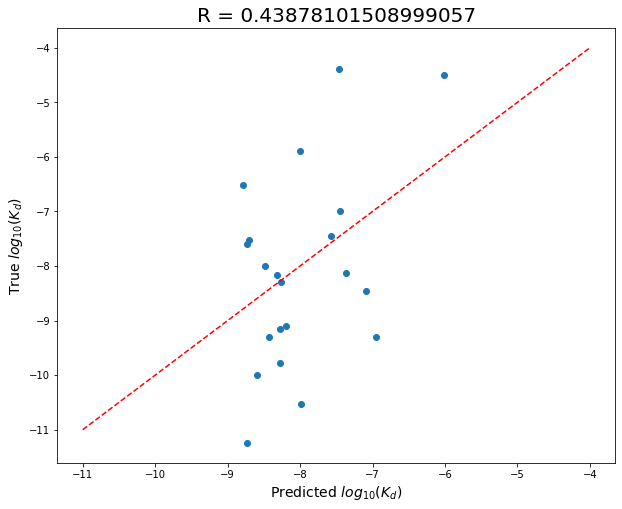

In [24]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.array(output_test), y_test[:,0].detach().numpy())
corr = np.corrcoef(np.array(output_test).T, y_test[:,0].detach().numpy().T)[1,0]
plt.plot([-11,-4],[-11,-4], c='r', linestyle='dashed')
plt.title('R = '+str(corr), size=title_size)
plt.xlabel('Predicted $log_{10}$($K_d$)', size=font_size)
plt.ylabel('True $log_{10}$($K_d$)', size=font_size)
plt.show()

Total image is product of this image
Total image is product of this image
Total image is product of this image
Total image is product of this image


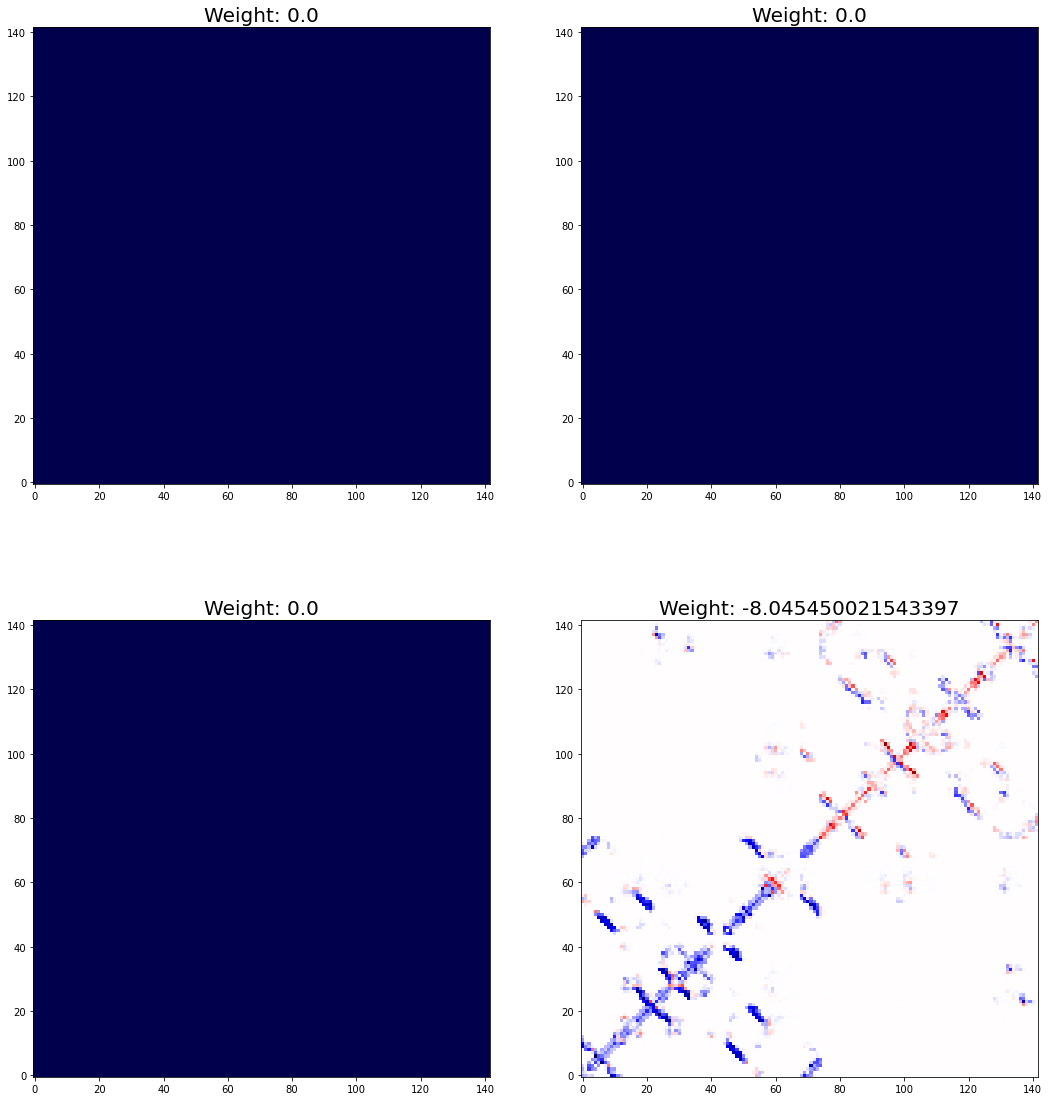

In [25]:
fig, axs = plt.subplots((n_filters+1)//2, 2, figsize=(18, 20))
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
learnt_filter = np.zeros((size_le, size_le))

for i, j in itertools.product(range((n_filters+1)//2), range(2)):
    if j == 1 and i == (n_filters+1)//2-1 and n_filters % 2 != 0:
        im_ = learnt_filter
    else:
        print('Total image is product of this image')
        im_ = np.multiply(np.mean(inter_filter, axis=0)[2*i+j], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[2*i+j].reshape(size_le, size_le))
        learnt_filter += im_
    im = axs[i,j].imshow(im_, origin='lower', cmap='seismic', norm=CenteredNorm())
    axs[i,j].set_title('Weight: '+str(im_.sum()), size=title_size)

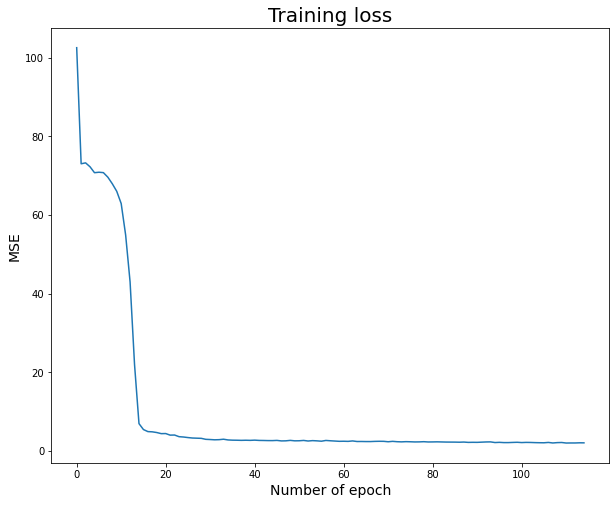

In [26]:
fig = plt.figure(figsize=(10, 8))
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

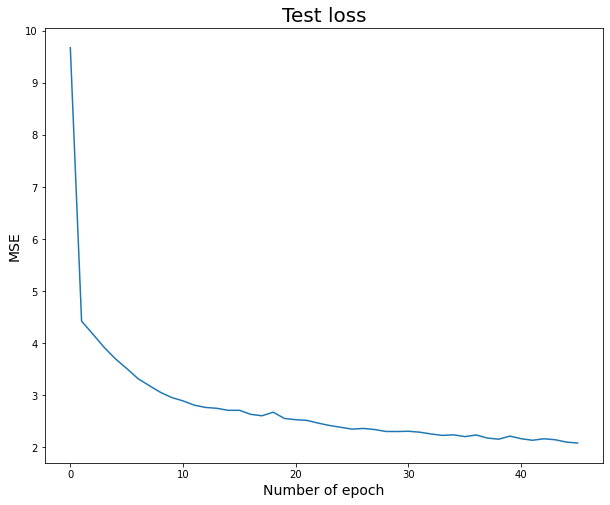

In [98]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[i] for i in range(len(test_losses))])
plt.title('Test loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

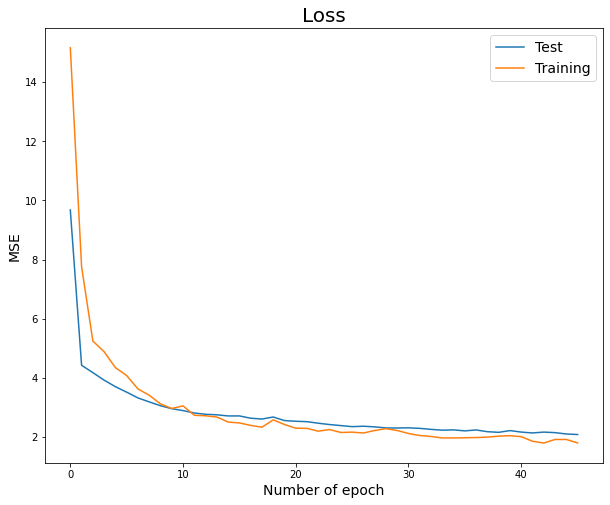

In [99]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[:][i] for i in range(len(test_losses[:]))])
plt.plot([train_losses[:][i] for i in range(len(train_losses[:]))])
plt.title('Loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.legend(['Test', 'Training'], prop={'size': font_size})
plt.show()

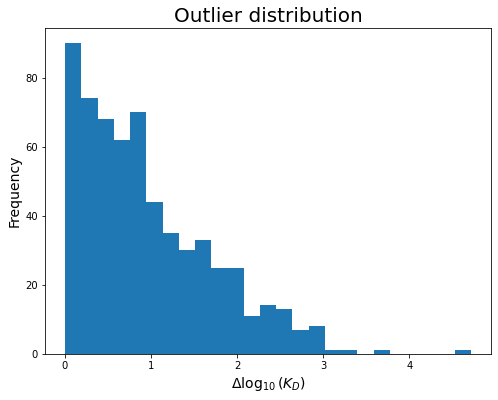

In [100]:
fig = plt.figure(figsize=(8, 6))
plt.title('Outlier distribution', size=title_size)
plt.hist(np.abs((model(train_x)[0]-train_y).detach().numpy()), 25)
plt.xlabel('$\Delta\log_{10}(K_D)$', size=font_size)
plt.ylabel('Frequency', size=font_size)
plt.show()

In [31]:
model(train_x[80:120])[0]

tensor([[-7.8488],
        [-8.8119],
        [-6.8079],
        [-8.4229],
        [-7.6609],
        [-8.6647],
        [-7.5039],
        [-7.3520],
        [-7.5180],
        [-8.0300],
        [-8.9547],
        [-7.4532],
        [-8.0866],
        [-7.6879],
        [-8.0589],
        [-6.1069],
        [-7.9266],
        [-6.8946],
        [-8.6947],
        [-8.1570],
        [-7.4921],
        [-6.7924],
        [-7.9947],
        [-8.2423],
        [-8.1894],
        [-7.9848],
        [-8.8121],
        [-8.3136],
        [-7.2671],
        [-7.5069],
        [-8.0406],
        [-8.3701],
        [-7.9674],
        [-8.3605],
        [-7.7745],
        [-9.2119],
        [-7.6806],
        [-7.9661],
        [-7.1673],
        [-6.9482]], grad_fn=<MmBackward0>)

In [32]:
train_y[80:120]

tensor([[ -8.7852],
        [ -9.3768],
        [ -6.0809],
        [ -9.8539],
        [ -7.0269],
        [-10.1904],
        [ -5.6737],
        [ -8.3979],
        [ -7.2396],
        [ -8.2291],
        [ -9.6990],
        [ -8.0044],
        [ -7.9586],
        [ -7.5086],
        [ -7.7959],
        [ -6.9101],
        [ -6.8210],
        [ -7.7799],
        [ -8.7447],
        [-10.3799],
        [ -6.7773],
        [ -6.1500],
        [ -7.8416],
        [ -9.7447],
        [ -8.2076],
        [ -8.1141],
        [ -9.3468],
        [ -9.3665],
        [ -7.7212],
        [ -6.8962],
        [ -8.0223],
        [ -9.0269],
        [ -8.2518],
        [ -9.9586],
        [ -8.7423],
        [-10.5229],
        [ -7.6576],
        [ -7.6383],
        [ -5.3979],
        [ -6.6021]])

# Training

In [42]:
##### Uncomment the following lines to save a checkpoint

path = '../checkpoints/model_epochs_' + str(len(train_losses)) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
save_checkpoint(path, model, optimiser, train_losses, test_losses)
np.save('../checkpoints/learnt_filter_epochs_'+str(len(train_losses))+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy', learnt_filter)

In [21]:
##### Uncomment the following lines to load a checkpoint

from antipasti.utils.torch_utils import load_checkpoint
#
nf_chckpt = 4
pool_chckpt = 2
k_chckpt = 4
ep_chckpt = 221
modes_chckpt = 'all'
input_shape = 292

path = '../checkpoints/contact_maps/seed_398/model_epochs_' + str(ep_chckpt) + '_modes_' + str(modes_chckpt) + '_pool_' + str(pool_chckpt) + '_filters_' + str(nf_chckpt) + '_size_' + str(k_chckpt) + '.pt'
model,optimiser,_,train_losses, test_losses = load_checkpoint(path, input_shape)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


## Hyperparametric search

In [193]:
n_max_epochs = 23
max_corr = 0.87
batch_size = 32

def objective(trial):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    
    n_filters = trial.suggest_categorical('n_filters', [2, 4, 8])
    filter_size = trial.suggest_int('filter_size', 3, 5)
    pooling_size = trial.suggest_int('pooling_size', 1, 3)
    learning_rate = trial.suggest_categorical('learning_rate', [5e-5, 1e-5, 4e-5, 1e-5])
    print('Filters:')
    print(n_filters)
    print('with size:')
    print(filter_size)
    print('Pooling size:')
    print(pooling_size)
    print('Learning rate:')
    print(learning_rate)
    fold = 0
    
    for train_index, val_index in kf.split(train_x):
        fold += 1
        train_loss = [100]
        val_loss = [100]
        train_x_fold, val_x_fold = train_x[train_index], train_x[val_index]
        train_y_fold, val_y_fold = train_y[train_index], train_y[val_index].reshape(val_x_fold.shape[0], 1, 1)          

        while val_loss[-1] > 5 or (val_loss[-1] > 2 and n_filters == 4 and filter_size == 4):
            model = ANTIPASTI(n_filters=n_filters, filter_size=filter_size, pooling_size=pooling_size, input_shape=input_shape, l1_lambda=0.002)
            criterion = MSELoss() 
            optimiser = AdaBelief(model.parameters(), lr=learning_rate, weight_decay=False, eps=1e-8, print_change_log=False) 
            train_loss, val_loss, _, _, _ = training_routine(model, criterion, optimiser, train_x_fold, val_x_fold, train_y_fold, val_y_fold, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size, verbose=False)

        print('Fold number')
        print(fold)            
        
        for i in range(20):
            previous_val_loss = np.mean(val_loss)
            if np.mean(val_loss) <= 1.2*np.mean(train_loss) and np.mean(val_loss) < 1.2*previous_val_loss and math.isnan(val_loss[-1]) == False:
                train_loss, val_loss, _, _, _ = training_routine(model, criterion, optimiser, train_x_fold, val_x_fold, train_y_fold, val_y_fold, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size, verbose=False)
                print(np.mean(val_loss))
                print(np.mean(train_loss))

        scores.append(np.mean(val_loss))
        print(f'Score for fold {fold}')
        print(scores)
        
    return np.mean(np.array(scores))


In [195]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-11-04 18:43:25,969] A new study created in memory with name: no-name-ada222f8-f214-4ff1-ad7b-660a773fef3c


Filters:
8
with size:
4
Pooling size:
1
Learning rate:
1e-05
Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


[W 2023-11-04 18:43:26,790] Trial 0 failed with parameters: {'n_filters': 8, 'filter_size': 4, 'pooling_size': 1, 'learning_rate': 1e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/kevinmicha/opt/anaconda3/envs/nma-cnn-env/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/4j/fmrt0mln14zcmrb74g6z93bh0000gn/T/ipykernel_40484/3691434214.py", line 38, in objective
    train_loss, val_loss, _, _, _ = training_routine(model, criterion, optimiser, train_x_fold, val_x_fold, train_y_fold, val_y_fold, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size, verbose=False)
                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/kevinm

KeyboardInterrupt: 